In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [6]:
evaluate_last_X_years = True
X=7
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'AUSS.OL'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount
## Pull historical USD national currency rates to dividend & calculate historical dividend in USD

In [7]:
# ticker_share = yf.Ticker(share_name)
# dividend = ticker_share.history(period='max', interval="1wk")
# dividend = dividend[dividend['Dividends'] > 0]
# dividend = dividend.rename(columns={'Dividends': 'local_amount'})

# dividend['real_date'] = dividend.index 
# dividend['real_date'] = dividend['real_date'].dt.tz_localize(None)

# dividend = dividend[['real_date', 'local_amount']]

# dividend['usd_rate'] = daily_price(ticker=currency_pair, end=dividend['real_date'], days_earlier=3)
# dividend['currency'] = [currency_pair.split(sep='=')[0] for x in range(len(dividend))]
# dividend['usd_dividend'] = dividend['local_amount'] / dividend['usd_rate']

# dividend.head()

## Extend your input statement table with historical dividend data and calculate share prices!

# 1.2. Raw input statement data

In [8]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [9]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,other_investing_cf_items,cash_from_investing,financing_cf_item,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,shares
0,2016-12-31,5323,-2510,2813,-743,0,496,93,2658,-509,...,-2055,-2466,949,0,0,954,1903,6,311,203
1,2017-03-31,6075,-3149,2926,-771,0,-1845,106,416,-72,...,17,-248,-98,-4,0,-695,-796,-1,686,203
2,2017-06-30,5019,-2398,2621,-659,0,-169,24,1817,-419,...,158,-311,-81,-947,0,689,-338,-4,-384,203
3,2017-09-30,4903,-2438,2465,-707,0,-1447,18,329,-58,...,44,-413,-85,0,0,-147,-232,-9,553,203
4,2017-12-31,4800,-2504,2296,-767,0,-1947,57,-361,-180,...,66,-584,-569,446,0,165,41,5,474,203


## Calculate date when quaterly reports could be available

In [10]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [11]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
23,2022-09-30,2022-10-21,203,9094,-5122,3972,1041,4282,3061,10781,...,12169,48093,2379,694,1742,7304,6131,32769,1660,-480
24,2022-12-31,2023-02-11,203,7658,-4175,3484,439,4340,2909,2956,...,11847,48062,2380,1153,1778,7879,5968,32741,561,-463
25,2023-03-31,2023-04-21,203,8002,-3972,4030,1224,4484,2972,11877,...,12177,50267,2164,1640,1734,8146,6061,33913,450,-471
26,2023-06-30,2023-07-21,203,8452,-4720,3732,-1139,5352,3270,12042,...,12301,51933,2617,1249,1414,7556,9051,37104,926,-440
27,2023-09-30,2023-10-21,203,8566,-5164,3402,-508,6654,3248,11454,...,12265,52401,2950,2466,1290,8635,8939,37918,1086,-478


## Pull historical average USD national currency rates and add to the dataframe

In [12]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
23,2022-09-30,2022-10-21,203,9094,-5122,3972,1041,4282,3061,10781,...,48093,2379,694,1742,7304,6131,32769,1660,-480,9.966961
24,2022-12-31,2023-02-11,203,7658,-4175,3484,439,4340,2909,2956,...,48062,2380,1153,1778,7879,5968,32741,561,-463,10.186402
25,2023-03-31,2023-04-21,203,8002,-3972,4030,1224,4484,2972,11877,...,50267,2164,1640,1734,8146,6061,33913,450,-471,10.221379
26,2023-06-30,2023-07-21,203,8452,-4720,3732,-1139,5352,3270,12042,...,51933,2617,1249,1414,7556,9051,37104,926,-440,10.699984
27,2023-09-30,2023-10-21,203,8566,-5164,3402,-508,6654,3248,11454,...,52401,2950,2466,1290,8635,8939,37918,1086,-478,10.483742


## Convert USD values related to IS, BS, CFS to national currency

In [13]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
23,2022-09-30,2022-10-21,203,9094,-5122,3972,1041,4282,3061,10781,...,48093,2379,694,1742,7304,6131,32769,1660,-480,9.966961
24,2022-12-31,2023-02-11,203,7658,-4175,3484,439,4340,2909,2956,...,48062,2380,1153,1778,7879,5968,32741,561,-463,10.186402
25,2023-03-31,2023-04-21,203,8002,-3972,4030,1224,4484,2972,11877,...,50267,2164,1640,1734,8146,6061,33913,450,-471,10.221379
26,2023-06-30,2023-07-21,203,8452,-4720,3732,-1139,5352,3270,12042,...,51933,2617,1249,1414,7556,9051,37104,926,-440,10.699984
27,2023-09-30,2023-10-21,203,8566,-5164,3402,-508,6654,3248,11454,...,52401,2950,2466,1290,8635,8939,37918,1086,-478,10.483742


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [14]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [15]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [16]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [17]:

obj = yf.Ticker(share_name)
share_price = obj.history(interval="1wk", start=data.date.min(), end=pd.Timestamp.now())
# add new date column due to pd.merge_asof match
share_price['real_date'] = share_price.index
# remove localization (timezone) to let merge the two columns
share_price['real_date'] = share_price['real_date'].dt.tz_localize(None)
# add share price column and keep the date and share prices
share_price['share_price'] = share_price['Close']
share_price = share_price[['real_date', 'share_price']]

share_price.tail()

,real_date,share_price
Date,,
2024-01-22 00:00:00+01:00,2024-01-22,75.750000
2024-01-29 00:00:00+01:00,2024-01-29,76.900002
2024-02-05 00:00:00+01:00,2024-02-05,76.150002
2024-02-12 00:00:00+01:00,2024-02-12,75.150002
2024-02-19 00:00:00+01:00,2024-02-19,74.800003


## Merge the statement dataset with share prices

In [18]:
merged_nat_curr = pd.merge_asof(left=share_price, right=ratios_nat_curr, on='real_date', direction='backward')
# drop rows with np.Nan and reset index
merged_nat_curr = merged_nat_curr.dropna()
merged_nat_curr = merged_nat_curr.reset_index(drop=True)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2017-02-13,57.423645,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,0.264221,0.735779,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498
1,2017-02-20,57.230953,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,0.264221,0.735779,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498
2,2017-02-27,55.882076,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,0.264221,0.735779,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498
3,2017-03-06,53.377018,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,0.264221,0.735779,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498
4,2017-03-13,53.762409,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,0.264221,0.735779,9.099145,6.693333,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [19]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,pfcf_ratio
0,2017-02-13,57.423645,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498,1.356096,1.260489,0.547483,2.276758
1,2017-02-20,57.230953,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498,1.351545,1.256259,0.545645,2.269118
2,2017-02-27,55.882076,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498,1.319691,1.226650,0.532785,2.215637
3,2017-03-06,53.377018,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498,1.260532,1.171662,0.508902,2.116315
4,2017-03-13,53.762409,2016-12-31,5323.0,42.344828,45.55665,203.0,5120.0,25.221675,2.645132,...,5.685447,1.274273,0.528461,0.40372,0.245593,0.929498,1.269633,1.180122,0.512576,2.131596


# Calculate Dividend yield and currency-share price correlation

In [20]:
obj = yf.Ticker(currency_pair)
obj2 = yf.Ticker(share_name)
usd_nat_curr = obj.history(interval="1d", start=merged_nat_curr['real_date'].min(), end=pd.Timestamp.now())
usd_nat_curr['date'] = usd_nat_curr.index
usd_nat_curr['date'] = usd_nat_curr['date'].dt.tz_localize(None)
usd_nat_curr['currency_rate'] = usd_nat_curr['Close']

In [21]:
share_all_price = obj2.history(interval="1d", start=merged_nat_curr['real_date'].min(), end=pd.Timestamp.now())
share_all_price['date'] = share_all_price.index
share_all_price['date'] = share_all_price['date'].dt.tz_localize(None)
share_all_price['share_price'] = share_all_price['Close']
share_all_price['dividend_yield'] = share_all_price['Dividends'] * 100 / share_all_price['Close']

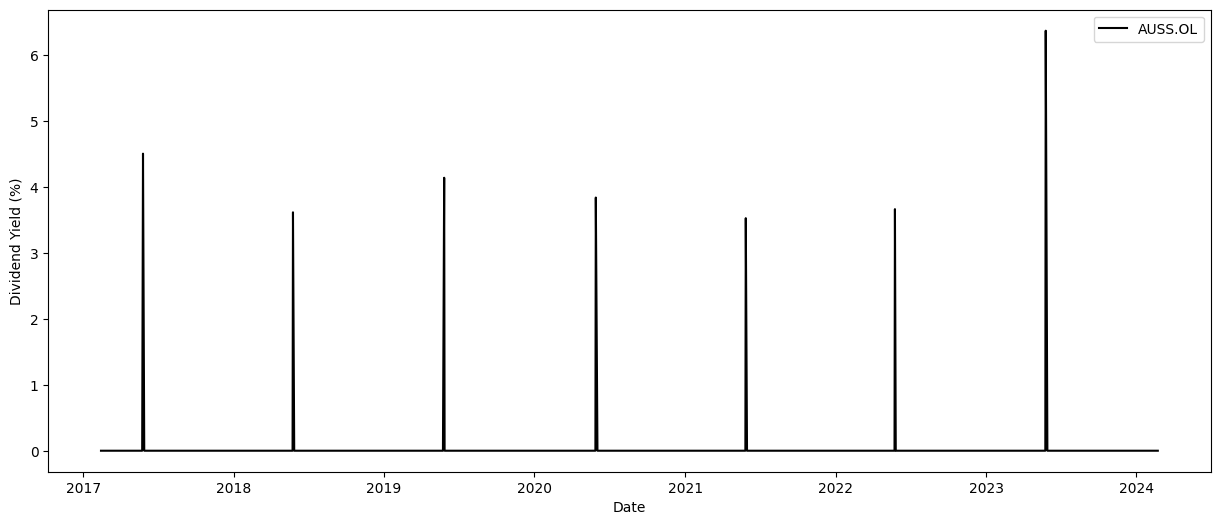

In [22]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(share_all_price.index, share_all_price['dividend_yield'], color='k', label=share_name)

ax1.set_xlabel('Date')
ax1.set_ylabel('Dividend Yield (%)', color='k')

plt.legend()
plt.show()

In [23]:
share_price_currency_rate_correlation = pd.merge_asof(left=usd_nat_curr, right=share_all_price, on='date')
share_price_currency_rate_correlation.index = share_price_currency_rate_correlation['date']
share_price_currency_rate_correlation = share_price_currency_rate_correlation[['currency_rate', 'share_price']]

share_price_currency_rate_correlation.corr()['share_price']

currency_rate    0.062027
share_price      1.000000
Name: share_price, dtype: float64

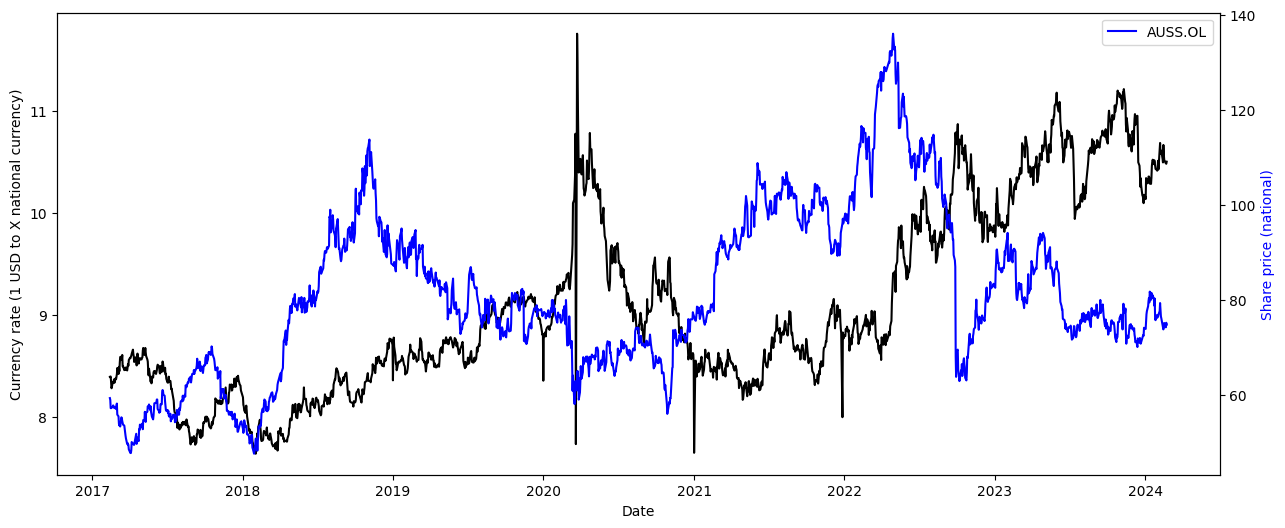

In [24]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
ax1.plot(usd_nat_curr.index, usd_nat_curr['Close'], color='k', label='USD / national currency')
ax2.plot(share_all_price.index, share_all_price['Close'], color='b', label=share_name)

ax1.set_xlabel('Date')
ax1.set_ylabel('Currency rate (1 USD to X national currency)', color='k')
ax2.set_ylabel('Share price (national)', color='b')

plt.legend()
plt.show()

# Share price and value ratios

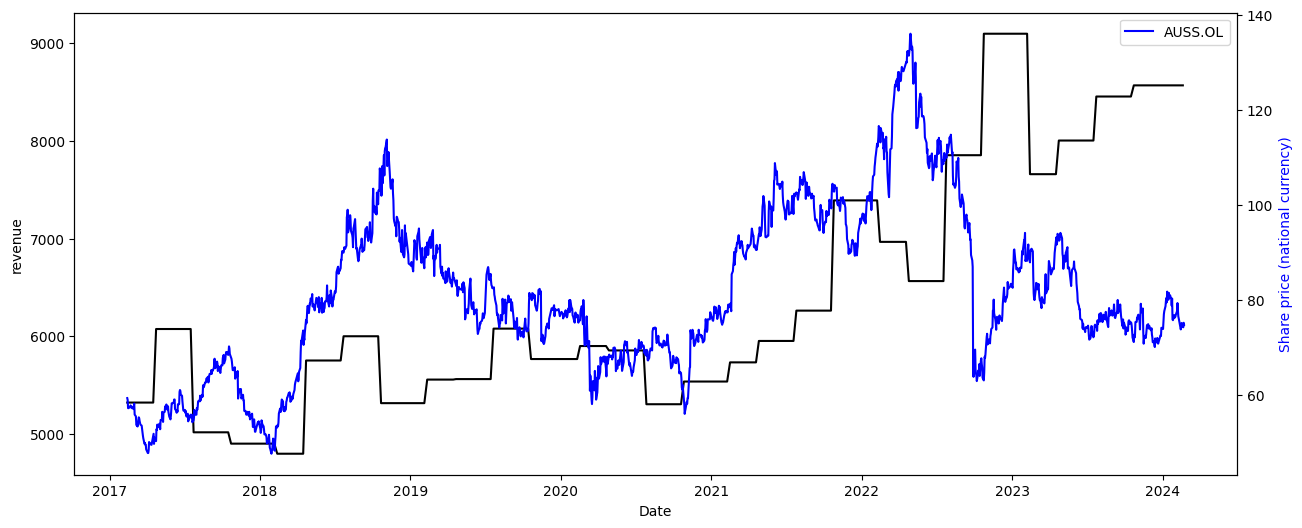

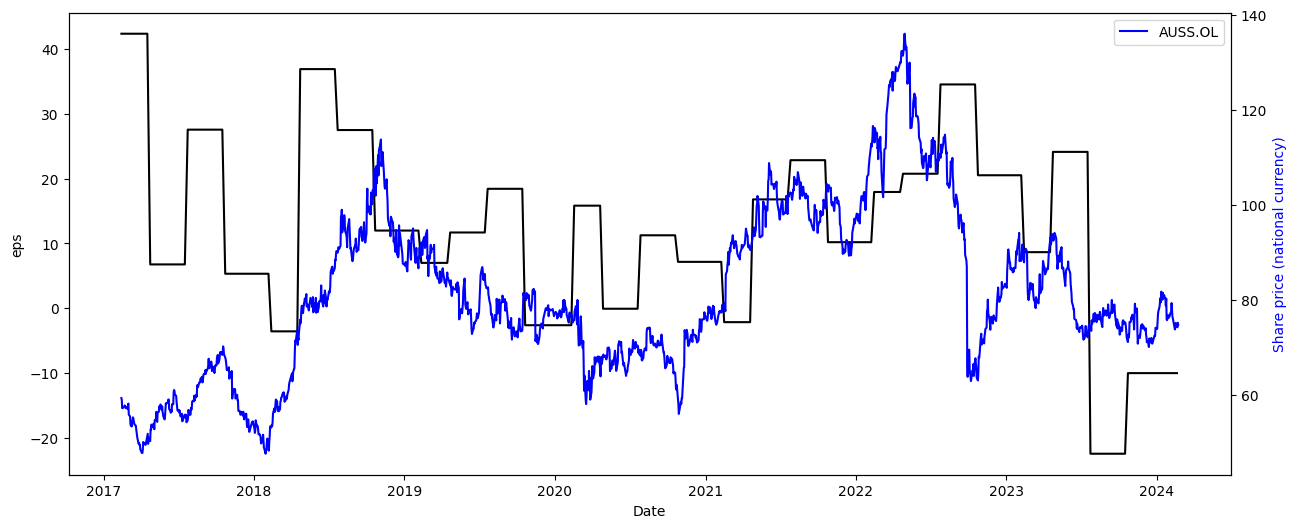

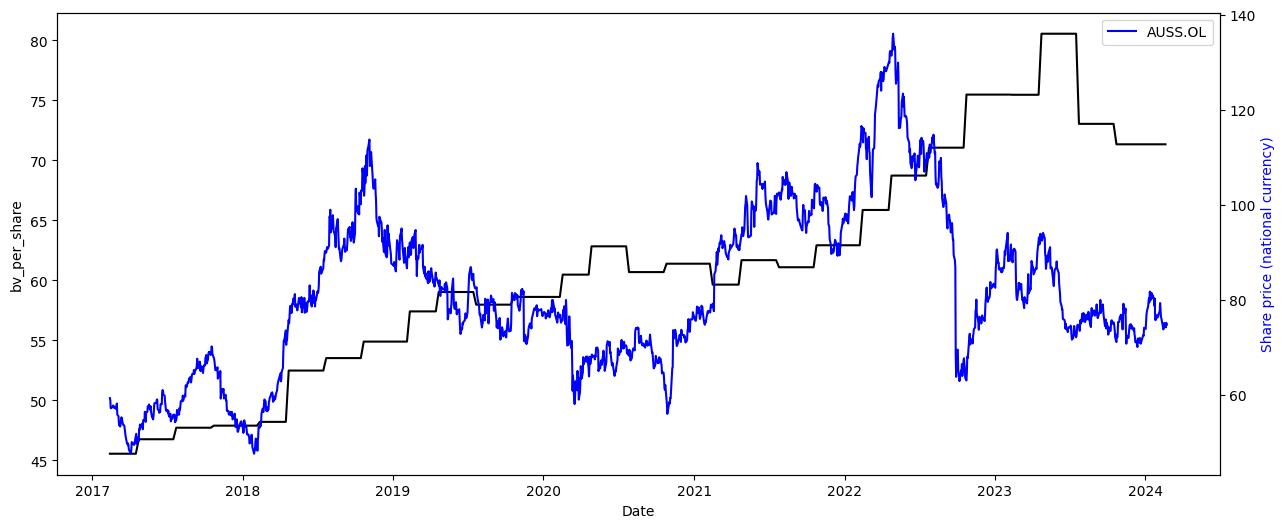

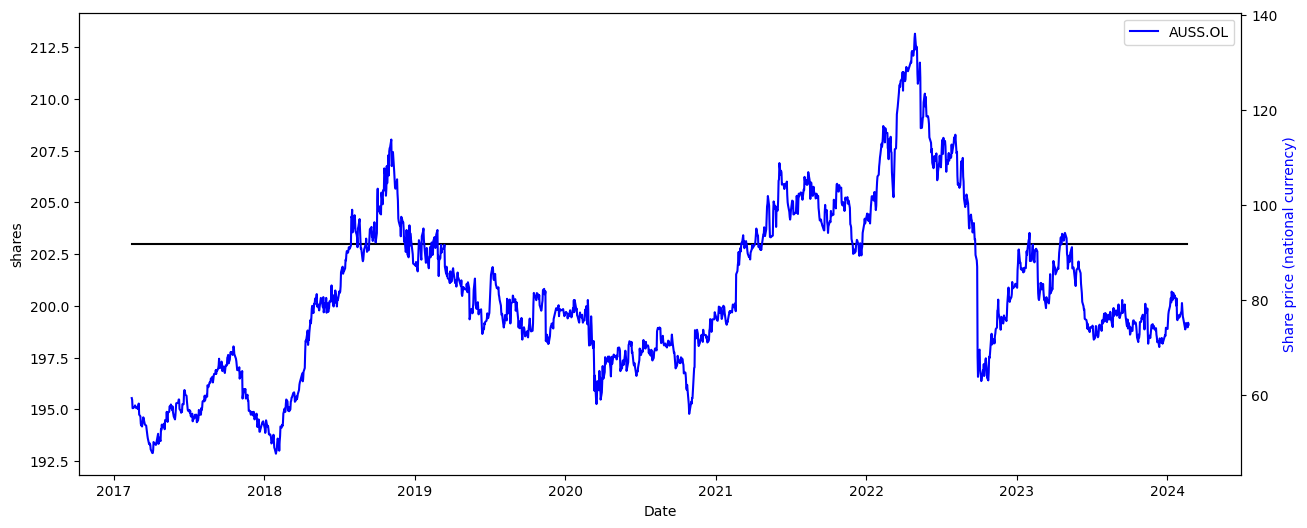

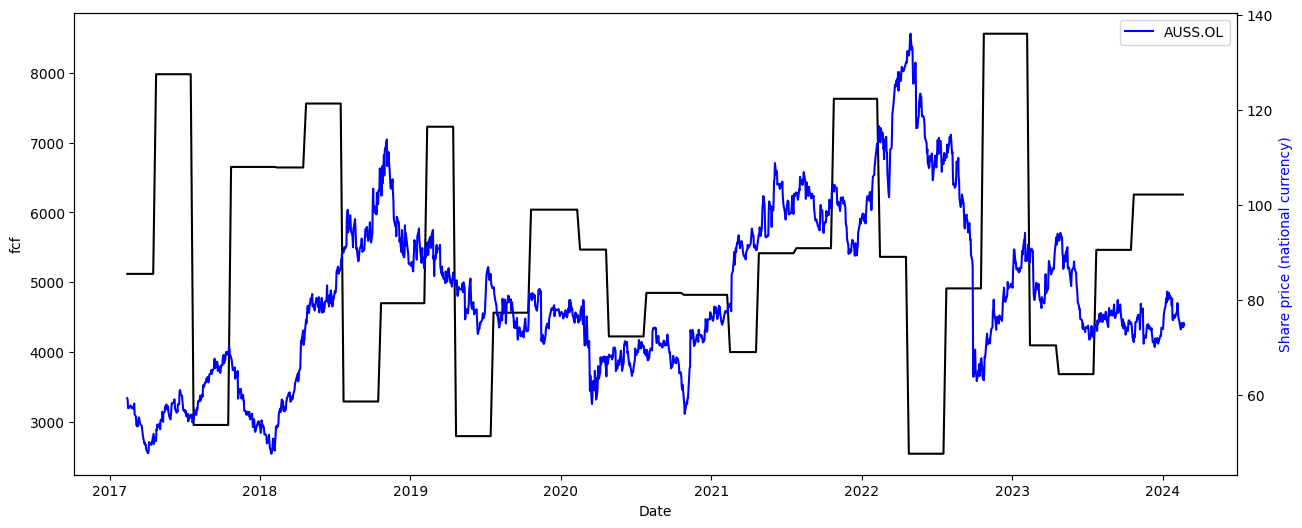

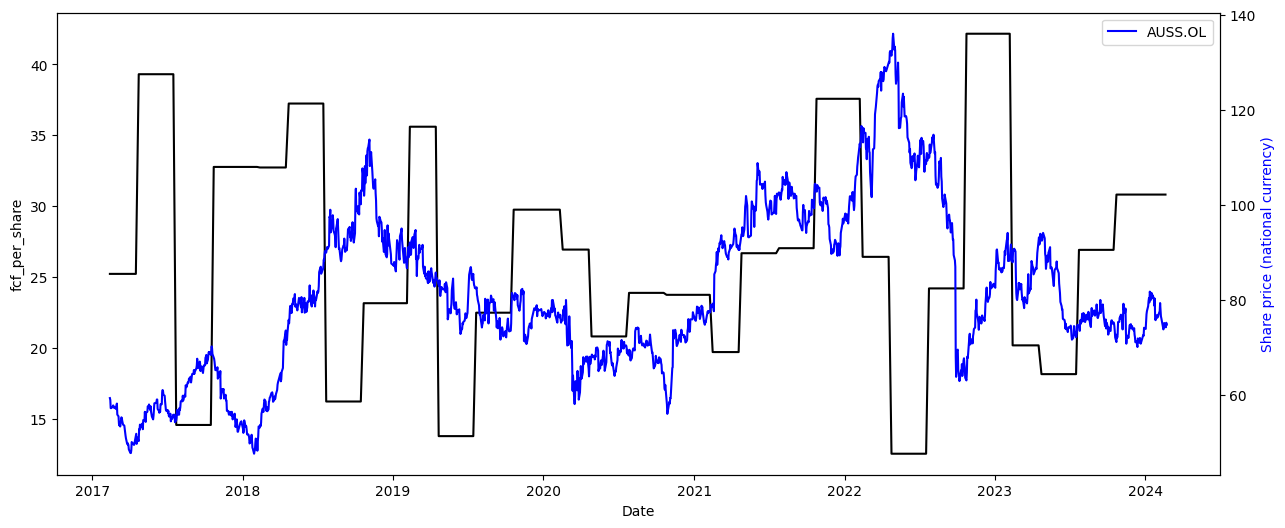

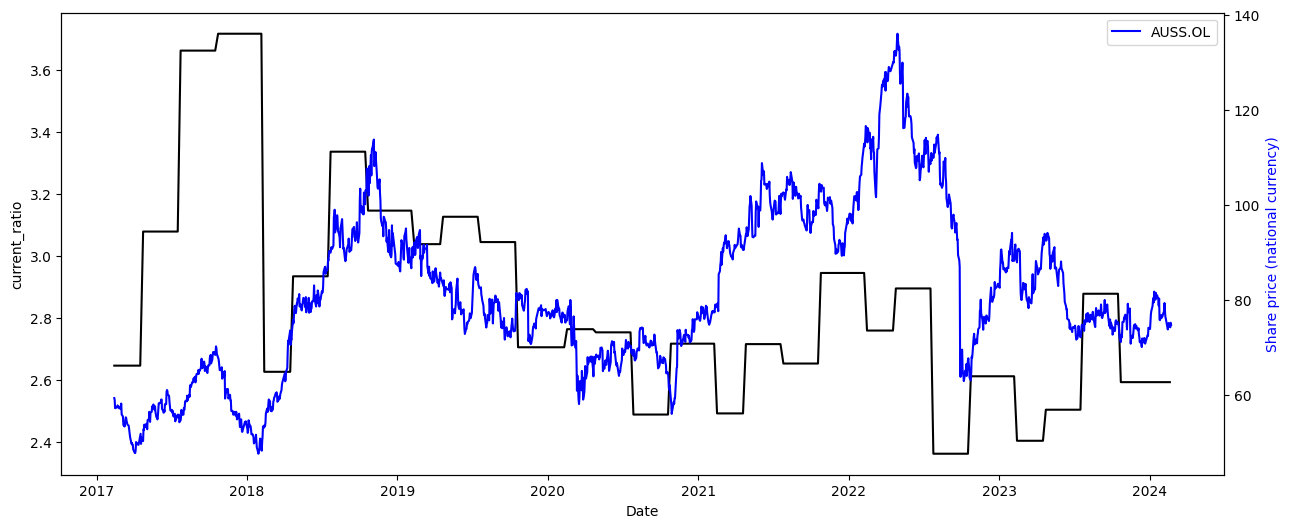

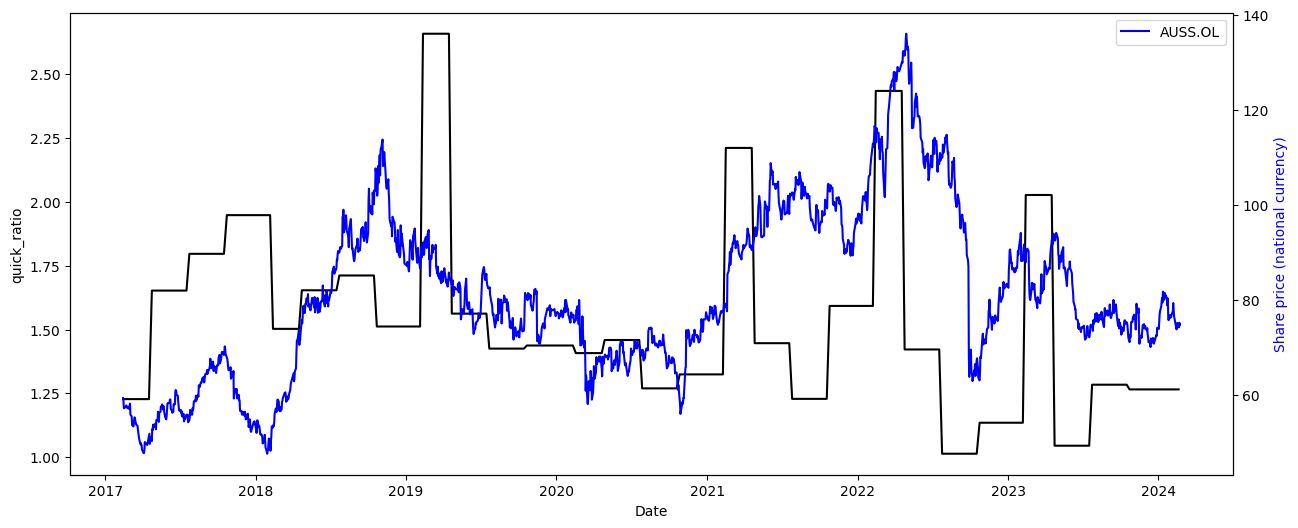

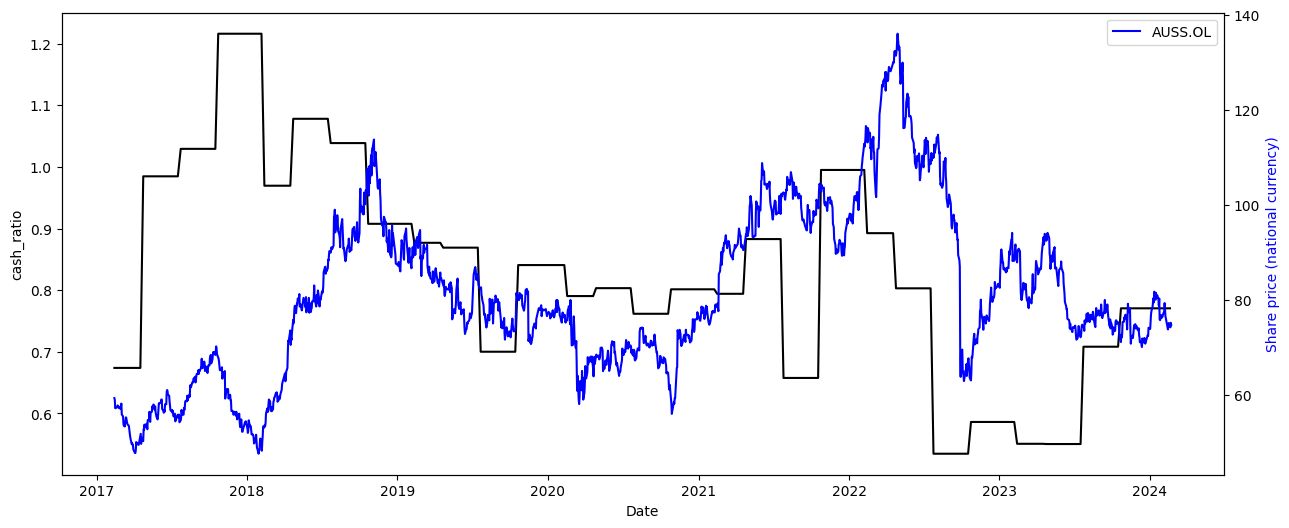

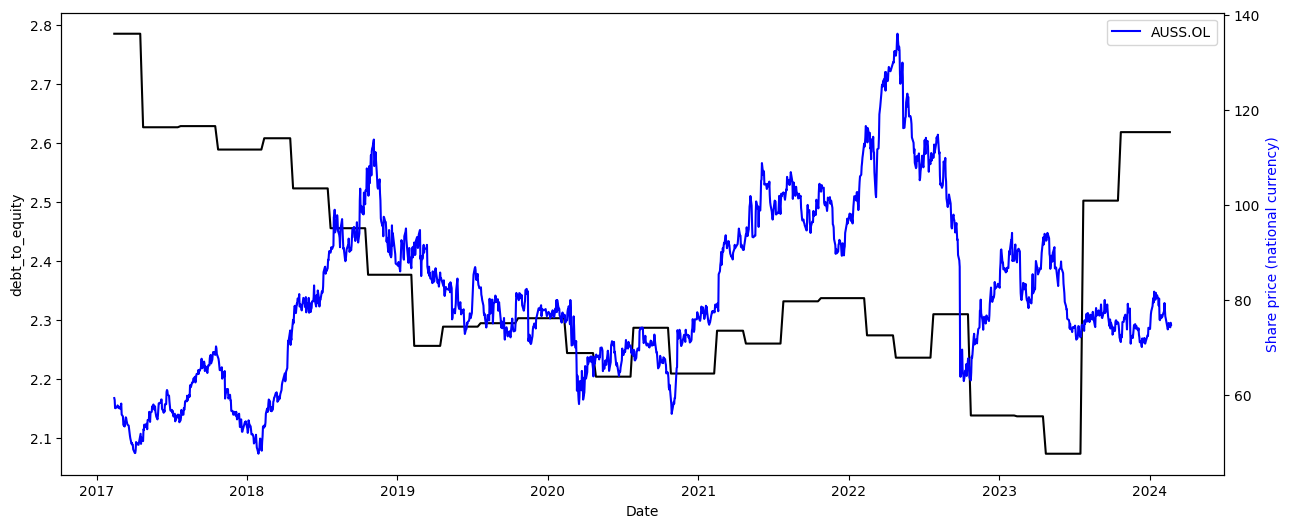

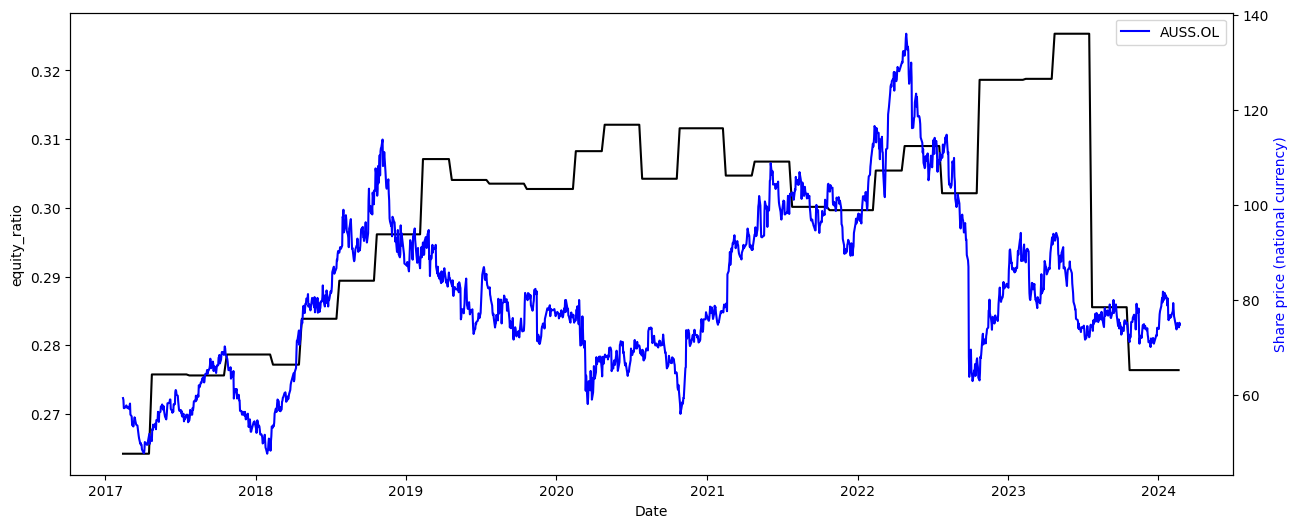

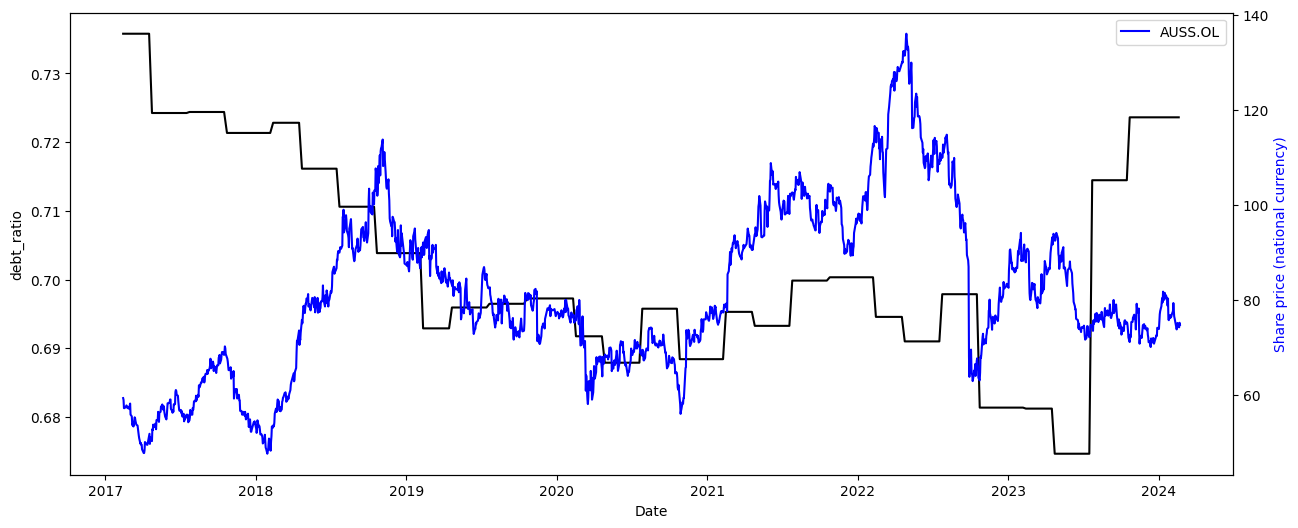

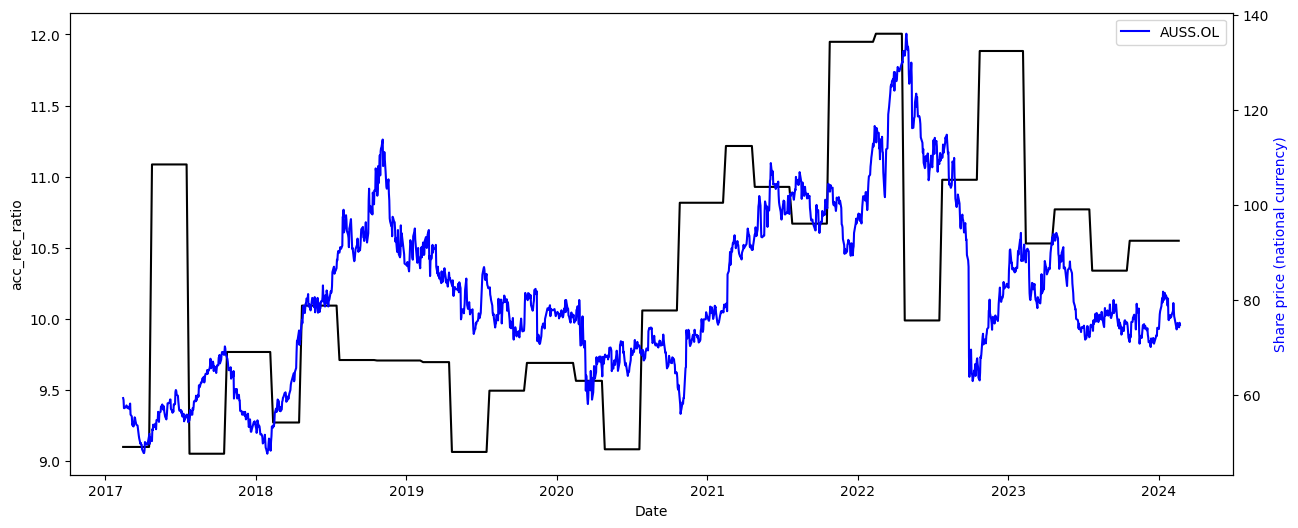

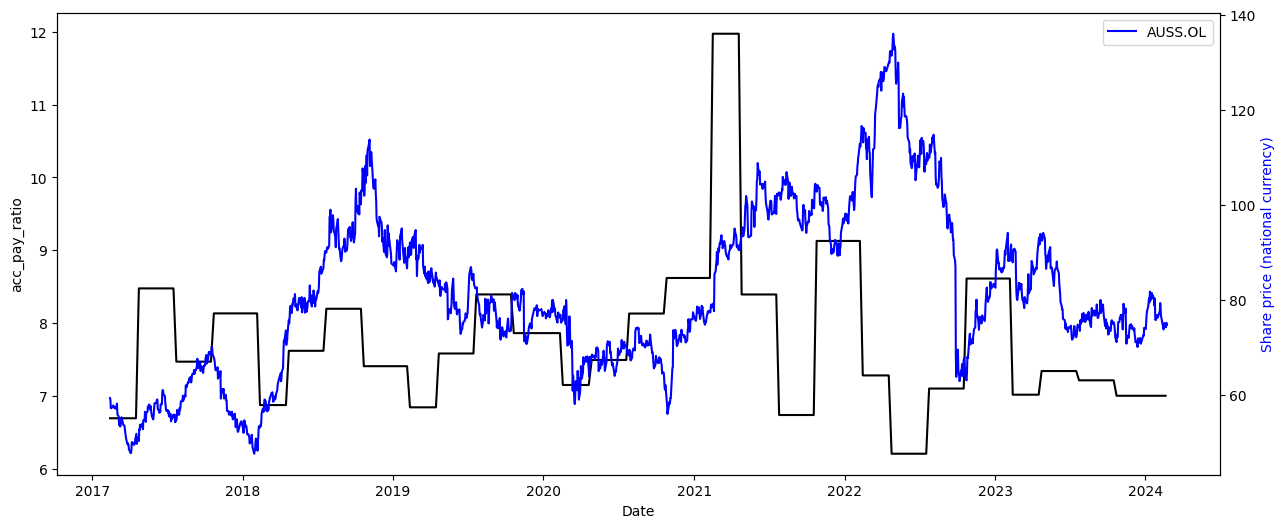

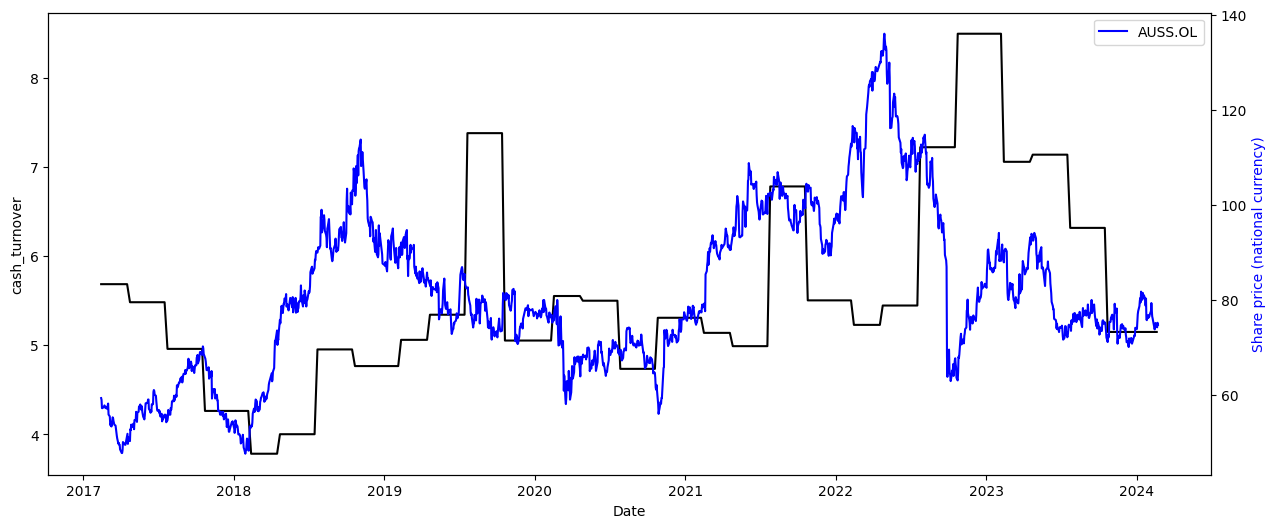

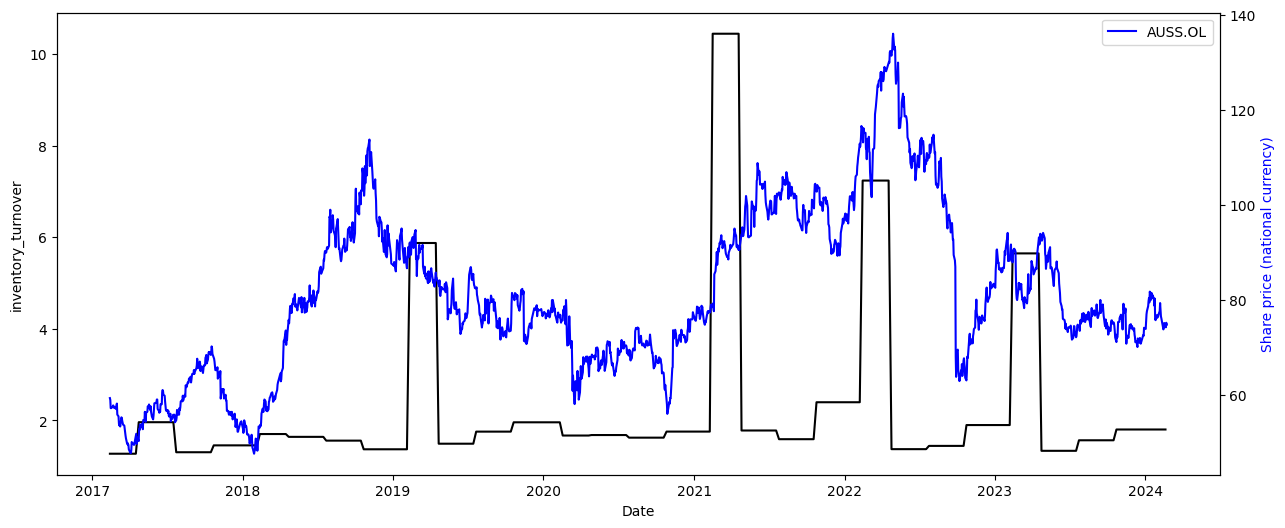

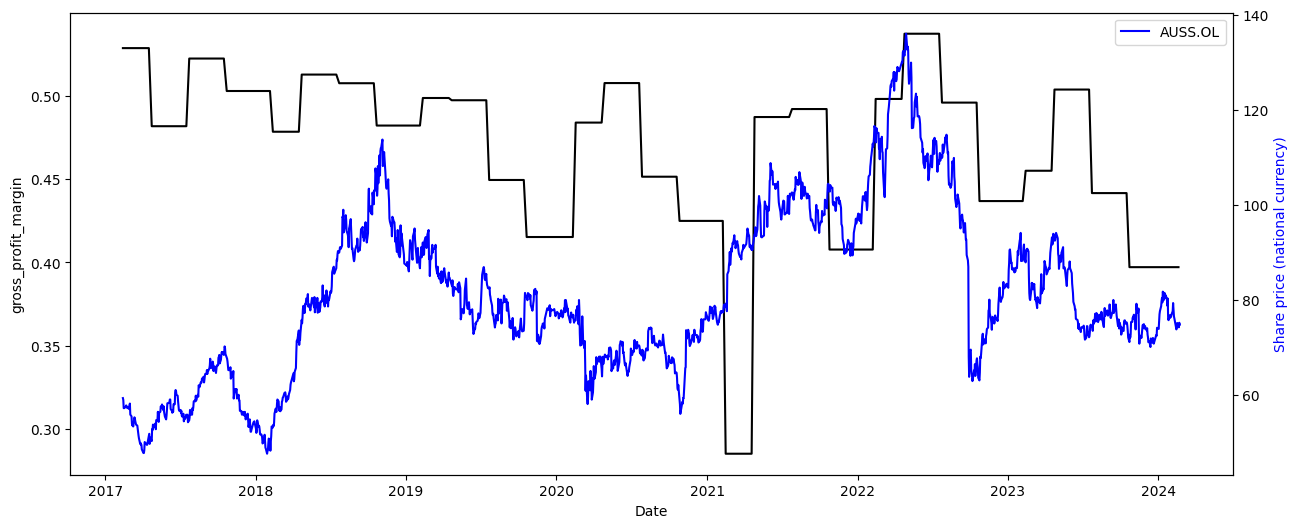

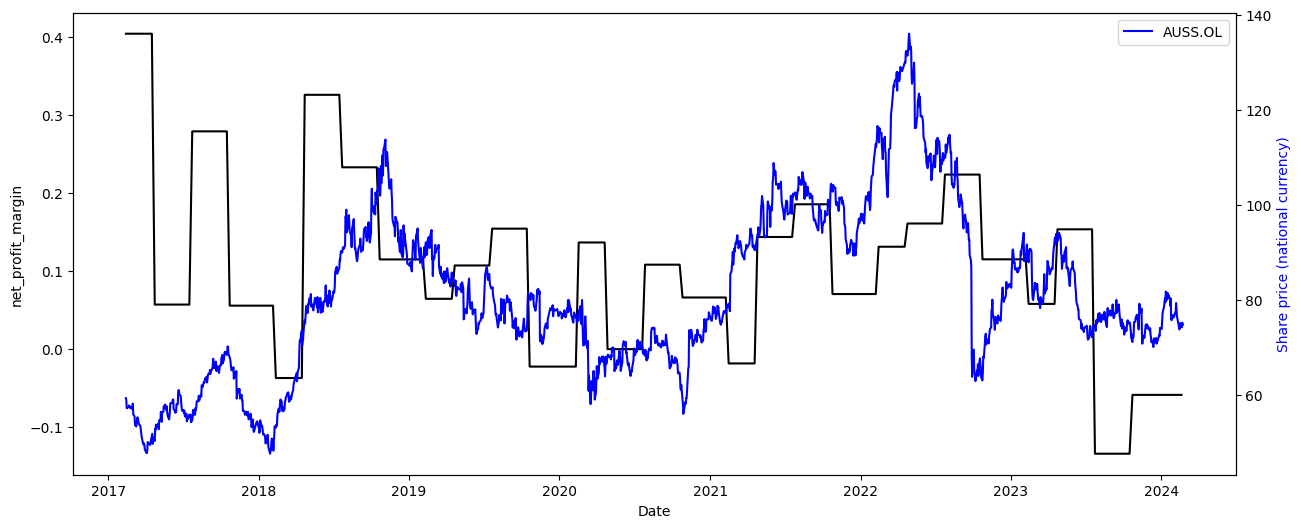

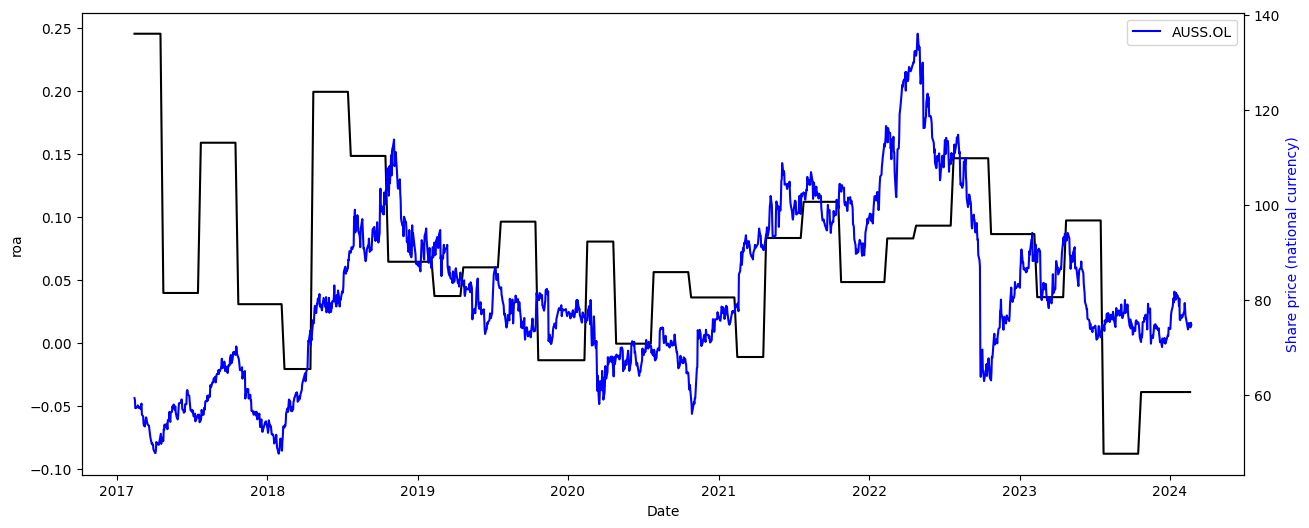

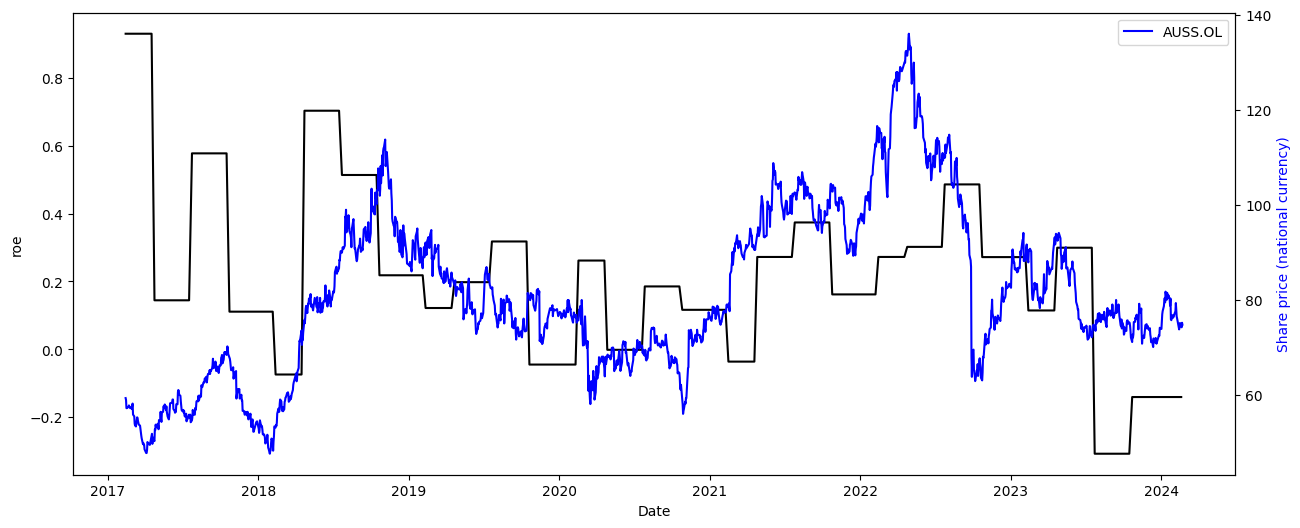

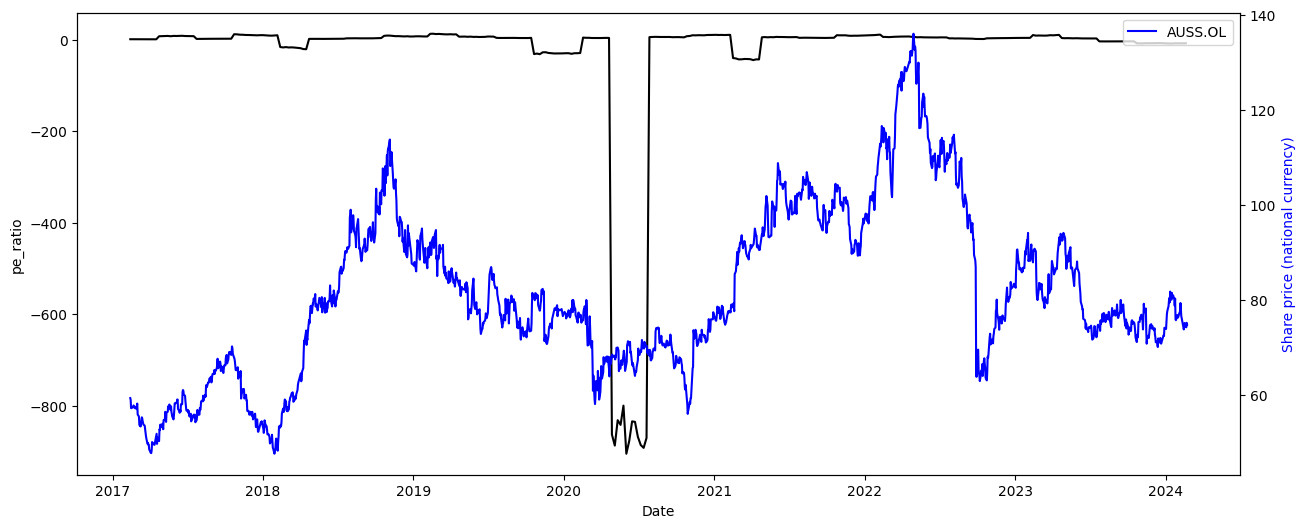

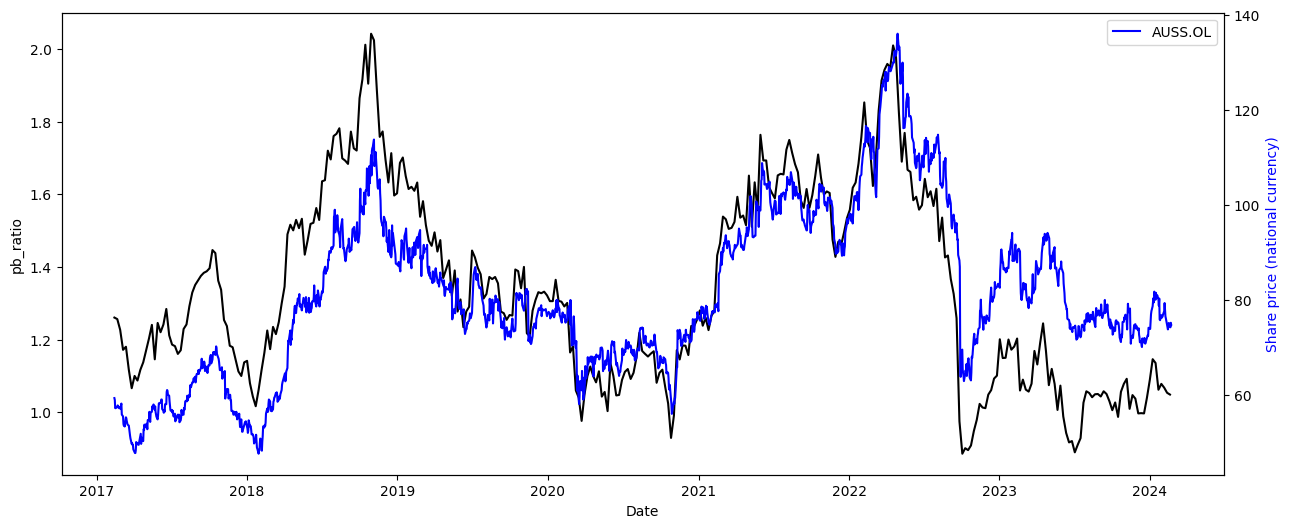

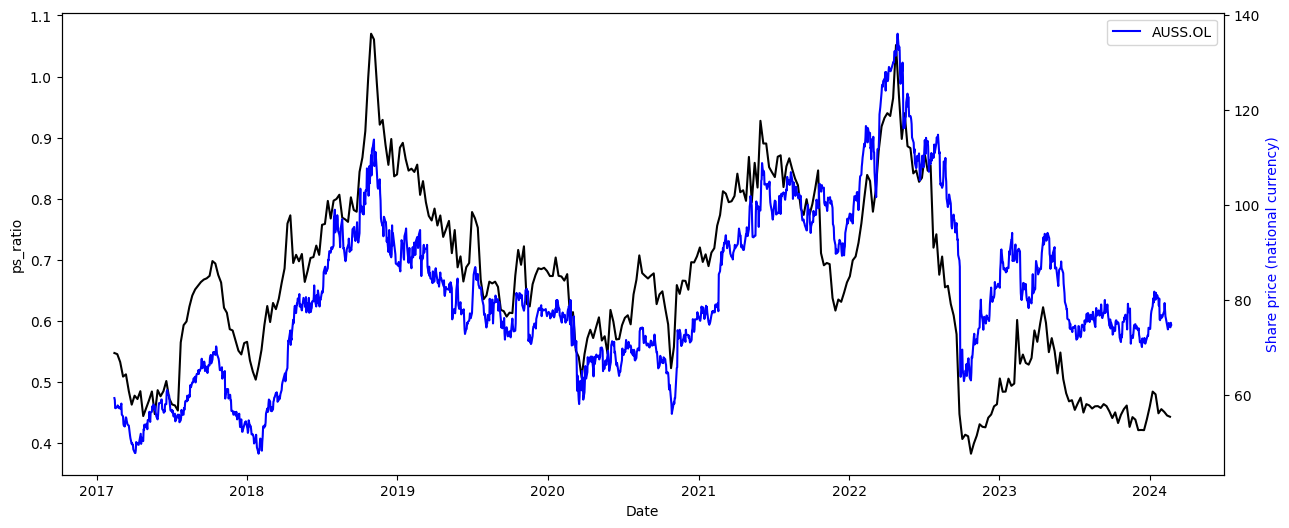

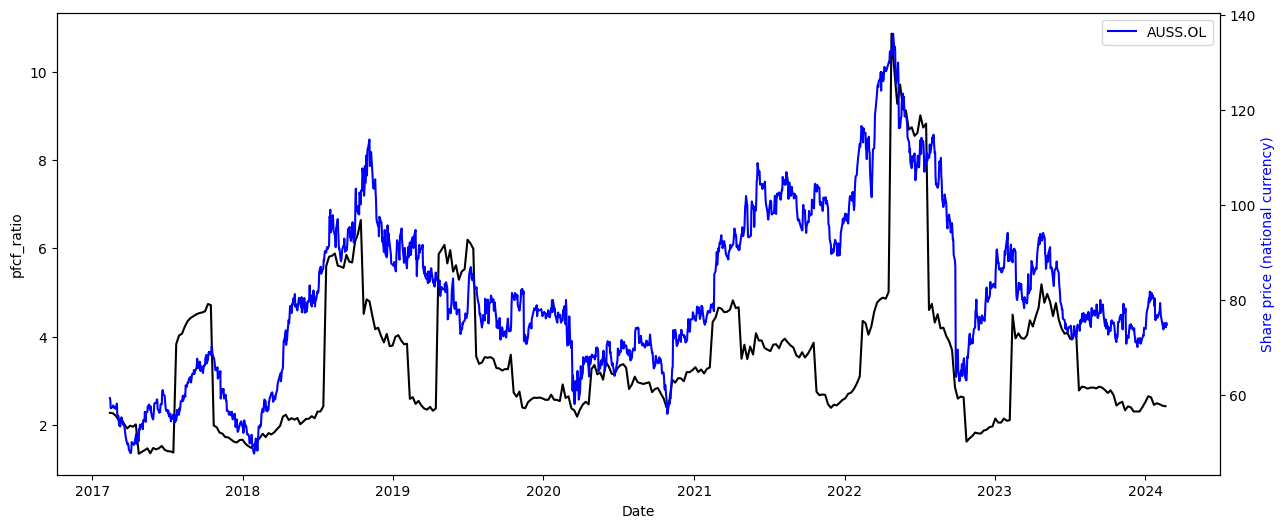

In [25]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(share_all_price.index, share_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

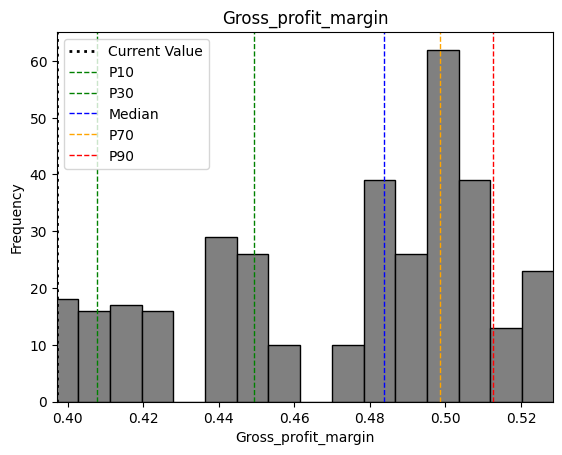

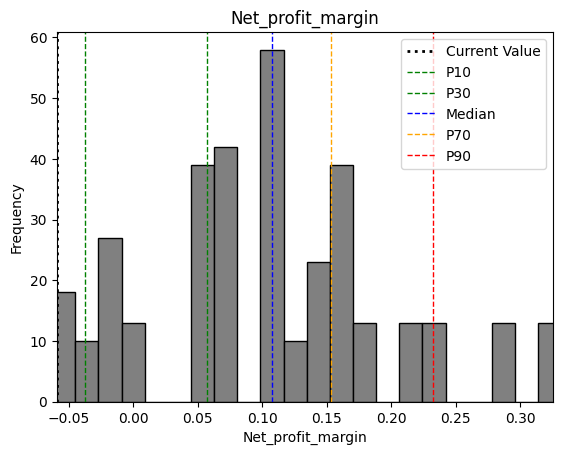

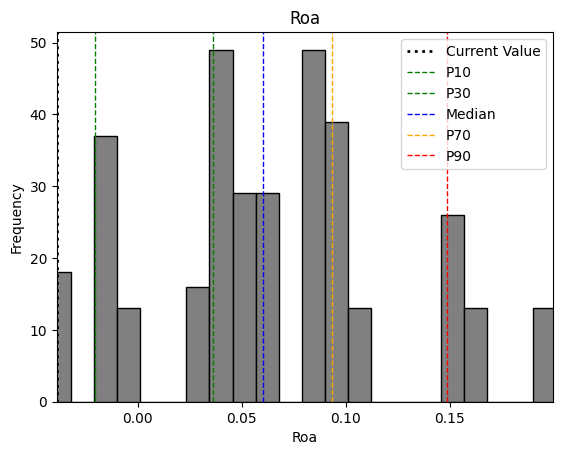

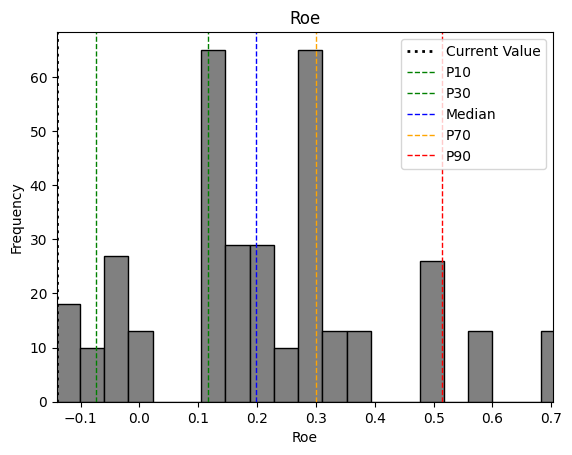

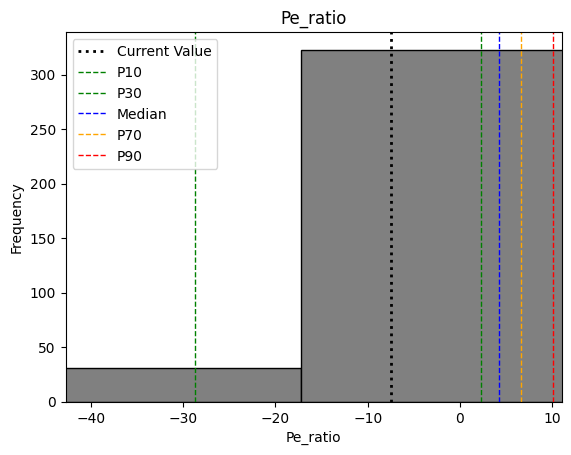

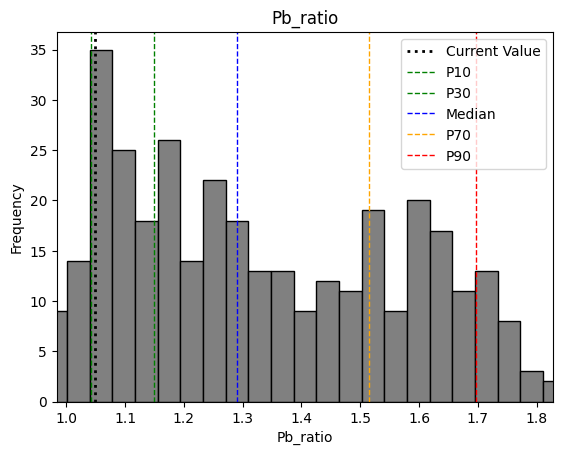

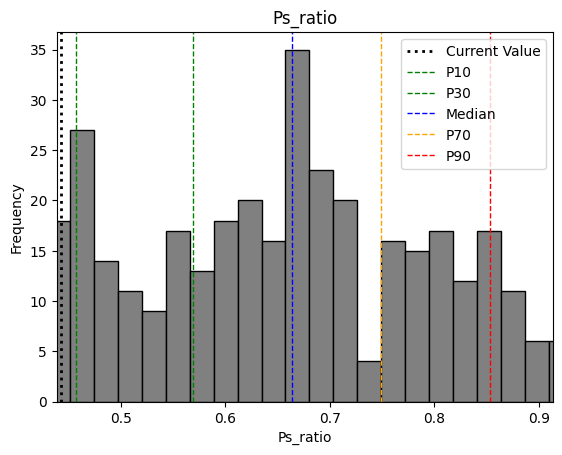

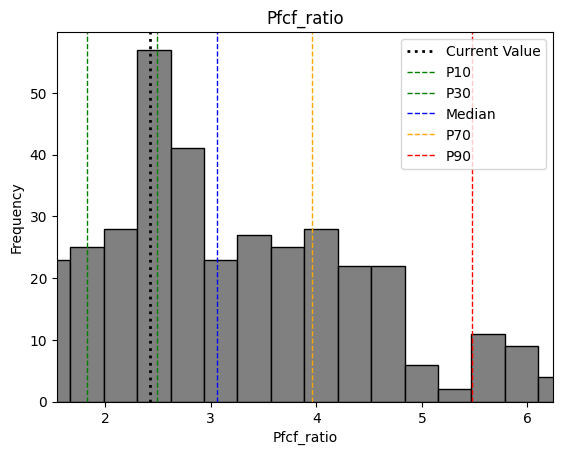

In [26]:
for column in merged_nat_curr.columns[-8:]:
    try:
        plt.hist(merged_nat_curr[column].values, bins=30, edgecolor='black', color='gray')
        plt.axvline(merged_nat_curr[column].iloc[-1], color='k', linestyle='dotted', linewidth=2, label='Current Value')
        plt.axvline(merged_nat_curr[column].quantile(0.1), color='green', linestyle='dashed', linewidth=1, label='P10')
        plt.axvline(merged_nat_curr[column].quantile(0.3), color='green', linestyle='dashed', linewidth=1, label='P30')
        plt.axvline(merged_nat_curr[column].quantile(0.5), color='blue', linestyle='dashed', linewidth=1, label='Median')
        plt.axvline(merged_nat_curr[column].quantile(0.7), color='orange', linestyle='dashed', linewidth=1, label='P70')
        plt.axvline(merged_nat_curr[column].quantile(0.9), color='red', linestyle='dashed', linewidth=1, label='P90')
        
        plt.xlabel(column.capitalize())
        plt.ylabel('Frequency')
        plt.title(column.capitalize())

        plt.xlim(merged_nat_curr[column].quantile(0.04), merged_nat_curr[column].quantile(0.96)) 
        
        plt.legend()

        plt.show()
    except:
        print(column + " diagram is missing due to error.")

## Calculate correlation between value parameters

In [27]:
corr_matrix = pd.DataFrame(merged_nat_curr, columns=['real_date', 'gross_profit_margin', 'net_profit_margin', 'roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'pfcf_ratio'])
# find independent columns
corr_matrix.corr()

,real_date,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,pfcf_ratio
real_date,1.000000,-0.383144,-0.372041,-0.348952,-0.388520,0.013756,-0.188913,-0.189944,0.187742
gross_profit_margin,-0.383144,1.000000,0.598356,0.581393,0.577711,-0.106649,0.156594,0.159309,0.260093
net_profit_margin,-0.372041,0.598356,1.000000,0.996443,0.995981,0.205723,0.315994,0.238242,0.229028
roa,-0.348952,0.581393,0.996443,1.000000,0.997312,0.203732,0.309879,0.213912,0.209328
roe,-0.388520,0.577711,0.995981,0.997312,1.000000,0.193803,0.300867,0.200611,0.184581
pe_ratio,0.013756,-0.106649,0.205723,0.203732,0.193803,1.000000,0.192523,0.093778,0.026974
pb_ratio,-0.188913,0.156594,0.315994,0.309879,0.300867,0.192523,1.000000,0.915410,0.504918
ps_ratio,-0.189944,0.159309,0.238242,0.213912,0.200611,0.093778,0.915410,1.000000,0.588953
pfcf_ratio,0.187742,0.260093,0.229028,0.209328,0.184581,0.026974,0.504918,0.588953,1.000000


In [28]:
tolerance = 0.2

In [29]:
gpm = merged_nat_curr[(merged_nat_curr['gross_profit_margin']<= merged_nat_curr['gross_profit_margin'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['gross_profit_margin']>= merged_nat_curr['gross_profit_margin'].iloc[-1] * (1- tolerance))]['date'].values
roe = merged_nat_curr[(merged_nat_curr['roe']<= merged_nat_curr['roe'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['roe']>= merged_nat_curr['roe'].iloc[-1] * (1- tolerance))]['date'].values
per = merged_nat_curr[(merged_nat_curr['pe_ratio']<= merged_nat_curr['pe_ratio'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['pe_ratio']>= merged_nat_curr['pe_ratio'].iloc[-1] * (1- tolerance))]['date'].values
pbr = merged_nat_curr[(merged_nat_curr['pb_ratio']<= merged_nat_curr['pb_ratio'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['pb_ratio']>= merged_nat_curr['pb_ratio'].iloc[-1] * (1- tolerance))]['date'].values
psr = merged_nat_curr[(merged_nat_curr['ps_ratio']<= merged_nat_curr['ps_ratio'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['ps_ratio']>= merged_nat_curr['ps_ratio'].iloc[-1] * (1- tolerance))]['date'].values
pfcfr = merged_nat_curr[(merged_nat_curr['pfcf_ratio']<= merged_nat_curr['pfcf_ratio'].iloc[-1] * (1+tolerance)) & (merged_nat_curr['pfcf_ratio']>= merged_nat_curr['pfcf_ratio'].iloc[-1] * (1- tolerance))]['date'].values

In [30]:
#test3 =  utils.list_intersect(gpm, roe)
#test4 =  utils.list_intersect(test3, per)
test5 =  utils.list_intersect(gpm, pbr)
test6 =  utils.list_intersect(test5, psr)
test7 =  utils.list_intersect(test6, pfcfr)
print(len(test7), 'timestemos have been found!')

63 timestemos have been found!


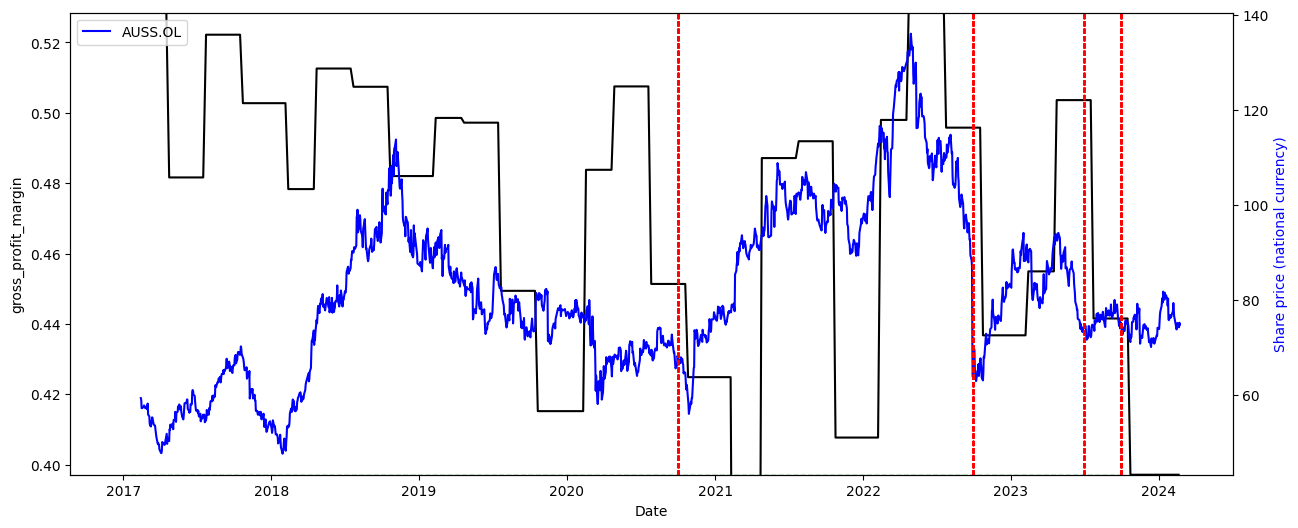

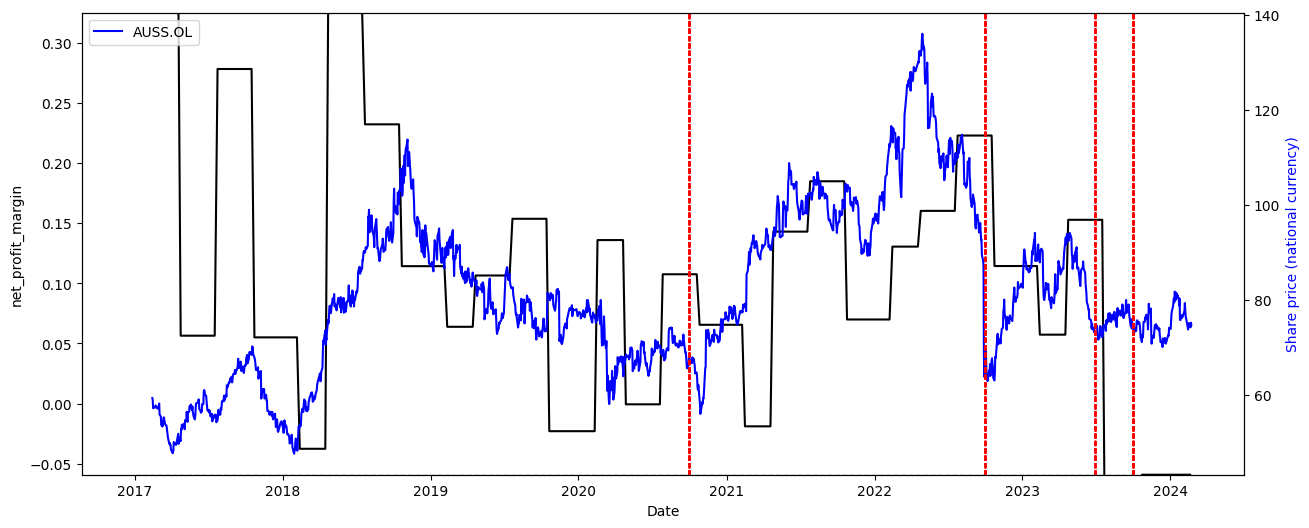

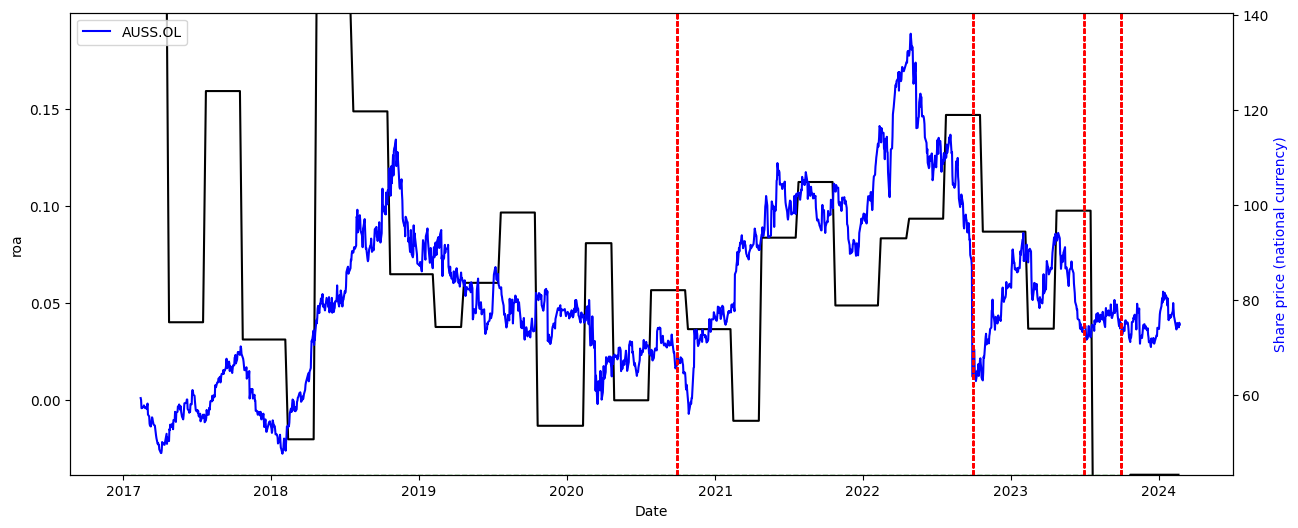

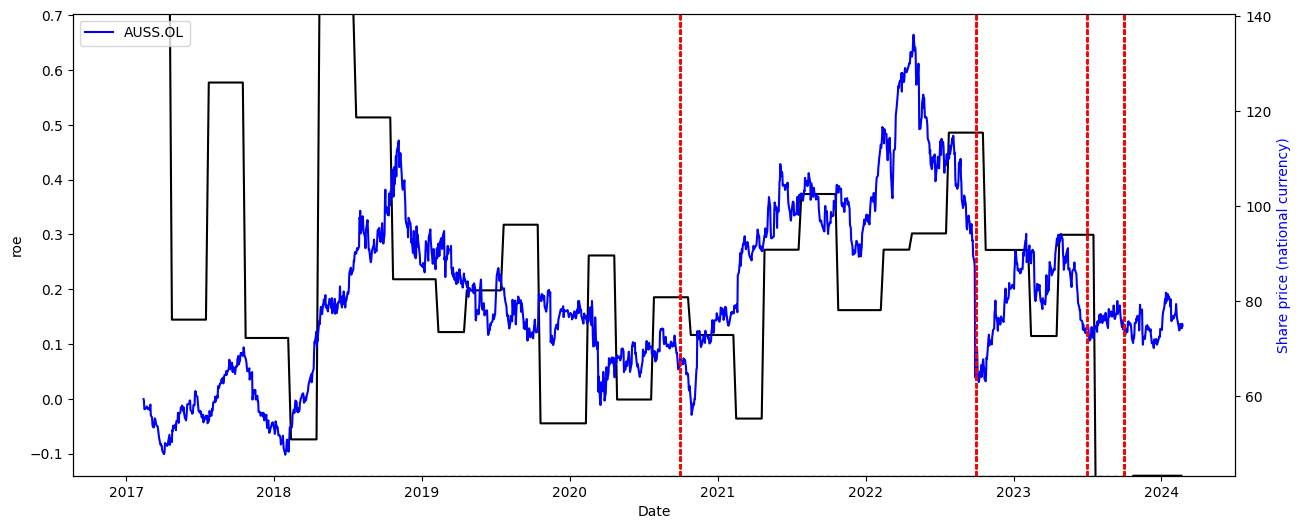

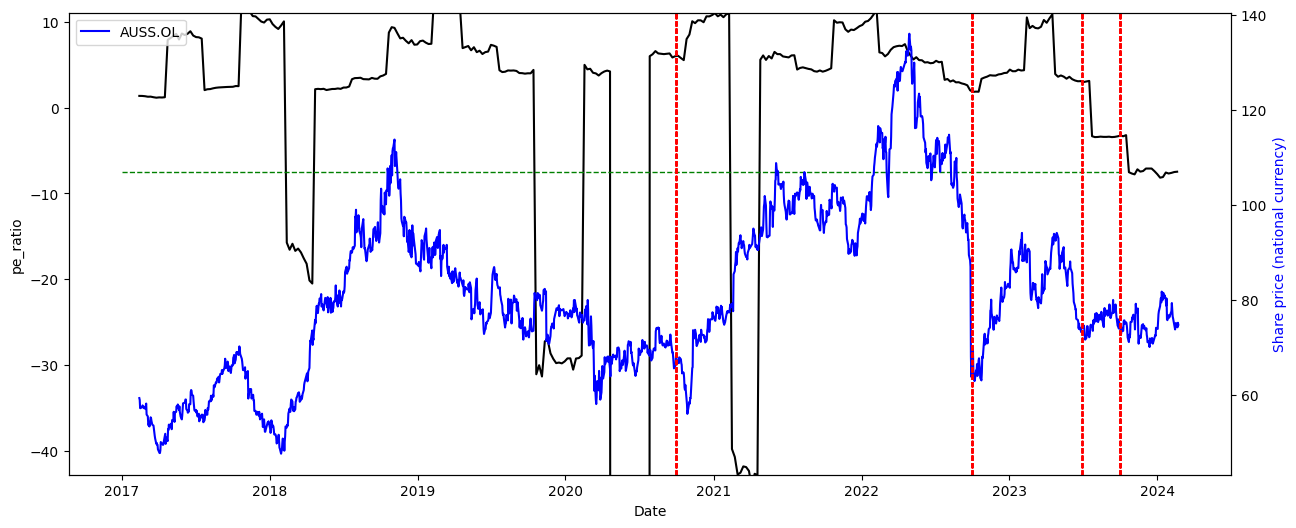

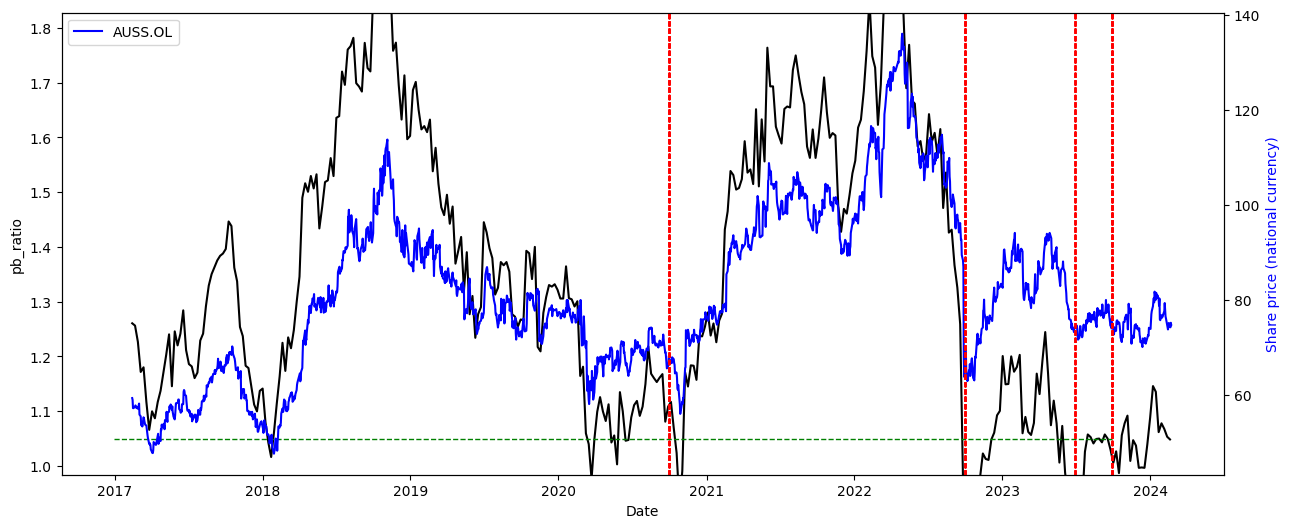

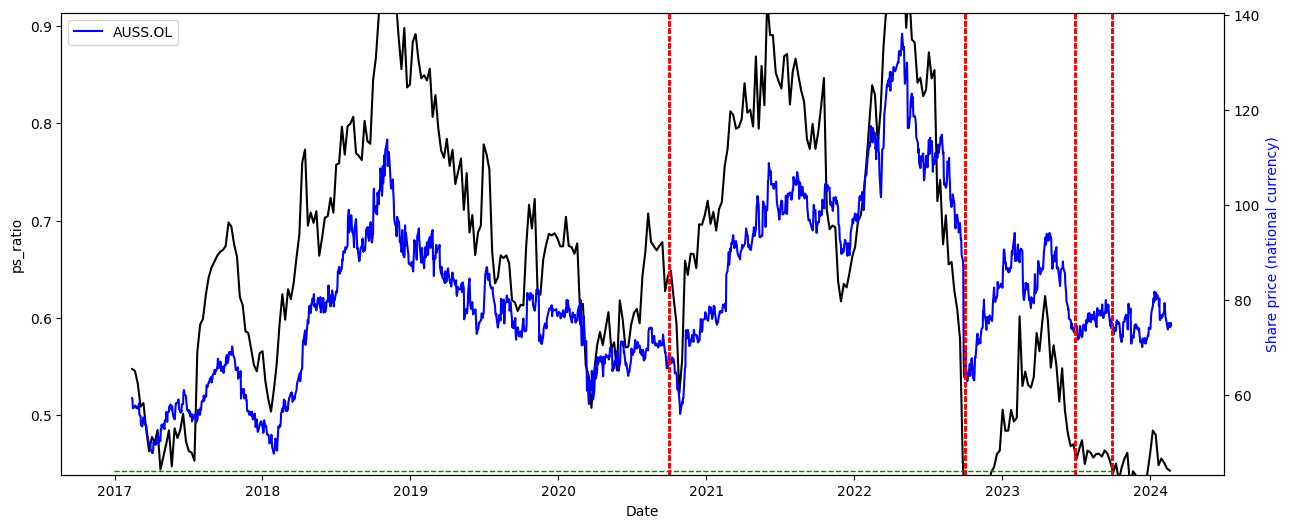

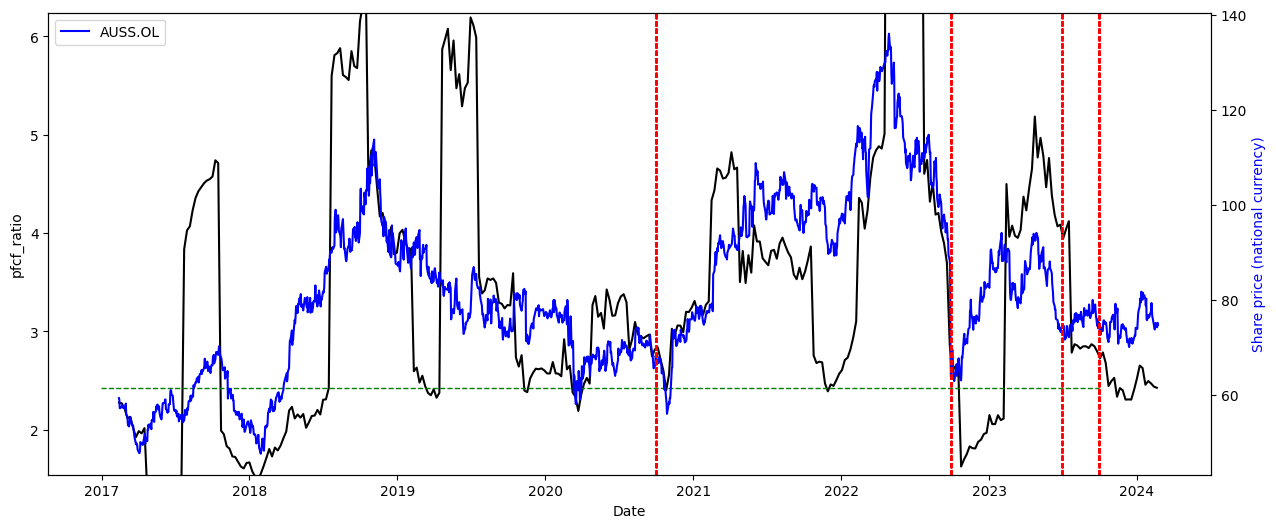

In [31]:
for column in merged_nat_curr.columns[-8:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(share_all_price.index, share_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax1.set_ylim(merged_nat_curr[column].quantile(0.04), merged_nat_curr[column].quantile(0.96)) 
    ax2.set_ylabel('Share price (national currency)', color='b')

    for timestamp in test7:
        plt.axvline(timestamp, color='red', linestyle='dashed', linewidth=1)

    ax1.hlines(
        y=merged_nat_curr[column].iloc[-1],
        xmin=merged_nat_curr.date.min(),
        xmax=merged_nat_curr.date.max(),
        linewidth=1, linestyles='dashed',
        color='green',
        )
    

    plt.legend()
    plt.show()